### INITIAL

#### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import time
import os
import fnmatch
import xlsxwriter
import random

import geopandas as gpd
import matplotlib.colors
import glob
import sys


#### PLT STYLE

In [70]:
plt.style.use('tableau-colorblind10')
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.bottom'] = 'False'
plt.rcParams['ytick.left'] = 'False'
plt.rcParams['font.size'] = 15

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
linestyle_t = ('solid', 'dashed', 'dashdot', 'dotted')


In [13]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

#### FUNCTIONS

In [59]:
# df.plot
def pdplot(df, xlab='xlabel', ylab='ylabel', xlim=(None, None), ylim=(None, None), legend=True, save=(0, datapath)):
    df.plot(grid=True, figsize=(9, 6))
    # xlab #
    plt.xlabel(xlab)
    # ylab #
    plt.ylabel(ylab)
    # xlim #
    if xlim == (None, None):
        plt.xlim(df.index[0], df.index[-1])
    else:
        plt.xlim(xlim[0], xlim[1])
    # ylim #
    if ylim == (None, None):
        pass
    else:
        plt.ylim(ylim[0], ylim[1])
    # legend #
    if legend:
        plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))
    # save #
    if save[0]:
        plt.savefig(save[1].split(".")[0] + "_raw.png")


# pyplot
def mypyplot(df, color=0, linestyle=0, xlab='xlabel', ylab='ylabel', xlim=(None, None), ylim=(None, None), legend=True, save=(False, None)):

    # color #
    n = len(df.columns)  # #variable n below should be number of curves to plot
    if color == 0:  # Mode0: Default
        plt.figure(figsize=(9, 6))
        for i in range(n):
            if linestyle == 1:  # Mode1: randoized  # https://www.geeksforgeeks.org/randomly-select-n-elements-from-list-in-python/
                get_index = random.randrange(len(linestyle_t))
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], linestyle=linestyle_t[get_index])
            else:
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i])                
    elif color == 1:  # Mode1: 'jet_r' (colors equally divided)  # https://stackoverflow.com/questions/28465028/pyplot-matplotlib-line-plot-same-color
        cmap = plt.get_cmap('jet_r')
        plt.figure(figsize=(9, 6))
        for i in range(n):
            color=cmap(float(i)/n)
            if linestyle == 1:  # Mode1: randoized
                get_index = random.randrange(len(linestyle_t))
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], c=color, linestyle=linestyle_t[get_index])
            else:
                plt.plot(df.index, df.iloc[:, i], label=df.columns[i], c=color)
    # xlab #
    plt.xlabel(xlab)
    # ylab #
    plt.ylabel(ylab)
    # xlim #
    if xlim == (None, None):
        plt.xlim(df.index[0], df.index[-1])
    else:
        plt.xlim(xlim[0], xlim[1])
    # ylim #
    if ylim == (None, None):
        pass
    else:
        plt.ylim(ylim[0], ylim[1])
    # legend #
    if legend:
        plt.legend(loc='upper left', ncol=1, bbox_to_anchor=(1, 1))
    # save #
    if save[0]:
        plt.savefig(save[1])

    
# https://note.com/shimakaze_soft/n/n725edcf789cf
def wareki2western(year):
    """和暦の年を西暦の年月日に変換する."""
    print('START >> wareki2western')
    try:
        if type(year) == str:
            if '令和' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('令和')[1].split('年')[0]) - 1
                year_west = (2019 + year_int)
            elif '平成' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('平成')[1].split('年')[0]) - 1
                year_west = (1989 + year_int)
            elif '昭和' in year:
                if '元年' in year:
                    year_int = 0
                else:
                    year_int = int(year.split('昭和')[1].split('年')[0]) - 1
                year_west = (1926 + year_int)
            else:
                print('year is none of "令和" , "平成" and "昭和"', year)
                year_west = np.nan

            return year_west
        else:
            print('type(year) is not str:', year)

            pass
        print('DONE >> wareki2western')

    except ValueError as e:
        raise e


#色定義
def colors_scale(arr):
    n_min = min(arr)
    n_max = max(arr)
    cmap = plt.cm.rainbow
    norm = matplotlib.colors.Normalize(vmin=n_min, vmax=n_max)
    arr = [cmap(norm(r)) for r in arr]
    return arr, cmap, norm



### 地価公示

RESOURCES:  
https://www.mlit.go.jp/totikensangyo/totikensangyo_fr4_000043.html  
https://www.land.mlit.go.jp/webland/servlet/MainServlet

2023.04.16 v000  
p: price  
f: fluctuation  
s: 商業  
j: 住宅  
c: concatenate

In [2]:
##### SETTINGS #####
filedir = r"C:\Users\A\Downloads"
filedir_exp = filedir

city = ['大阪市', '横浜市', '渋谷区', '新宿区']
column_names = []
for i in range(len(city)):
    column_names.append('商業 ' + city[i])
for i in range(len(city)):
    column_names.append('住宅 ' + city[i])

# File
filename = '001595567.xls'
datapath = filedir + '\\' + filename


In [3]:
##### 価格推移表 #####
##### DATA PROCESSING #####
df_p = pd.read_excel(datapath, sheet_name=2, index_col=[2, 1])  # sheet 2
df_p = df_p.drop(df_p.index[[0]], axis=0)  # Drop 1st index
df_p = df_p.drop(df_p.columns[[0]], axis=1)  # Drop 1st column
df_p = df_p.T
df_p = df_p / 1_000_000  # million
df_p_s = df_p['商業']

df_p_c = pd.concat([df_p['商業'][city], df_p['住宅'][city]], axis=1)
df_p_c.columns = column_names  # change column names
new_index = pd.Series(df_p_c.index).apply(wareki2western)  # apply the function to the DataFrame index
df_p_c.index = new_index  # assign the new index to the DataFrame


In [4]:
df_p_c.head(3)

,商業 大阪市,商業 横浜市,商業 渋谷区,商業 新宿区,住宅 大阪市,住宅 横浜市,住宅 渋谷区,住宅 新宿区
1975,0.4661,0.3063,0.66,1.2271,0.0976,0.0611,0.1944,0.1946
1976,0.4676,0.3128,0.6686,1.2181,0.0978,0.0614,0.1957,0.1952
1977,0.4753,0.3152,0.653,1.1446,0.0992,0.0623,0.2007,0.198


#### 価格

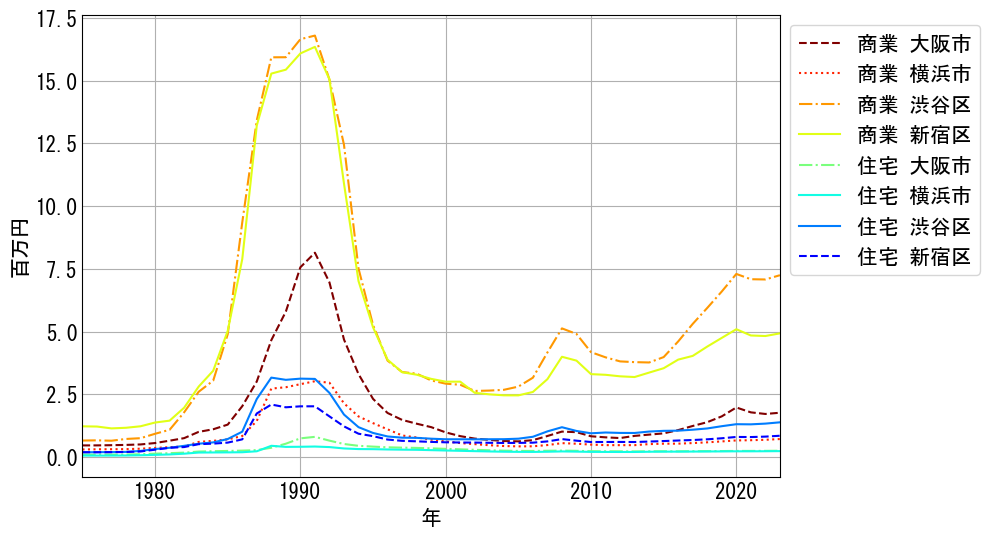

In [61]:
mypyplot(df_p_c, color=1, linestyle=1, xlab='年', ylab='百万円')

In [20]:
##### 変動率推移表 #####
##### DATA PROCESSING #####
df_f = pd.read_excel(datapath, sheet_name=1, index_col=[2,1])  # sheet 1
df_f = df_f.drop(df_f.index[[0]], axis=0)  # Drop 1st index
df_f = df_f.drop(df_f.columns[[0]], axis=1)  # Drop 1st column
df_f = df_f.T

In [21]:
df_f_c = pd.concat([df_f['商業'][city], df_f['住宅'][city]], axis=1)
df_f_c.columns = column_names  # change column names
new_index = pd.Series(df_f_c.index).apply(wareki2western)  # apply the function to the DataFrame index
df_f_c.index = new_index  # assign the new index to the DataFrame
df_f_c.iloc[0, :] = 1  # normalize to the oldest data
df_f_c_s = df_f_c.cumsum()  # cumlative sum

In [22]:
df_f_c_s.head(3)

,商業 大阪市,商業 横浜市,商業 渋谷区,商業 新宿区,住宅 大阪市,住宅 横浜市,住宅 渋谷区,住宅 新宿区
1975,1,1,1,1,1,1,1,1
1976,1.1,1.2,1.5,-0.6,1.2,1.3,1.6,1.3
1977,2.5,1.5,3.5,0.4,2.7,2.5,3.6,3.4


#### 変動率

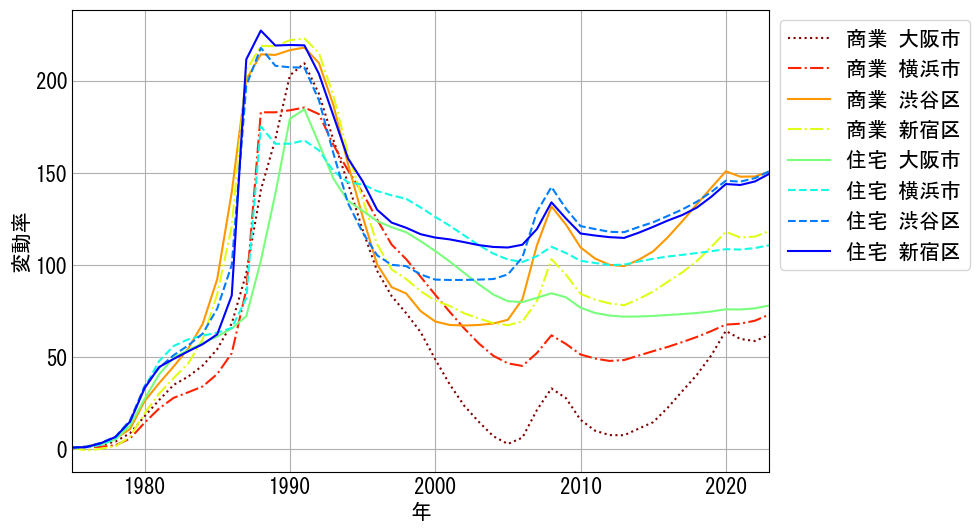

In [62]:
mypyplot(df_f_c_s, color=1, linestyle=1, xlab='年', ylab='変動率')

### 不動産取引価格

REFERENCES:  



In [63]:
##### SETTINGS #####
# RealState data
filedir = r"C:\Users\A\Downloads\27_Osaka Prefecture_20224_20224"
filedir_exp = filedir
filename = '27_Osaka Prefecture_20224_20224.csv'
datapath = filedir + '\\' + filename

# 市区町村のshapeデータ
geofile = r"C:\Users\A\Downloads\N03-20220101_27_GML\N03-22_27_220101.geojson"
gdf = gpd.read_file(geofile, encoding='SHIFT-JIS')

In [64]:
##### DATA PROCESSING #####

# RealState data
df = pd.read_csv(datapath, encoding="cp932")  # sheet 2
# df = df_p.drop(df_p.columns[[0]], axis=1)  # Drop 1st column
df['建築年'] = df['建築年'].apply(wareki2western)
# count
df_p = df.groupby('市区町村名').count()

# 市区町村の重心を取得
gdf['centroid'] = gdf['geometry'].centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
year is none of "令和" , "平成" and "昭和" 戦前
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is not str: nan
type(year) is n

In [76]:
gdf

,N03_001,N03_002,N03_003,N03_004,N03_007,geometry,centroid,x,y,count
0,大阪府,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((135.09176 34.31282, 135.09174 ...",POINT (135.50573 34.62459),135.505726,34.624594,0
1,大阪府,NaN,大阪市,都島区,27102,"POLYGON ((135.51481 34.72057, 135.51489 34.720...",POINT (135.52721 34.71193),135.527214,34.711927,40
2,大阪府,NaN,大阪市,福島区,27103,"POLYGON ((135.48403 34.69969, 135.48404 34.699...",POINT (135.47534 34.69390),135.475339,34.693895,53
3,大阪府,NaN,大阪市,此花区,27104,"POLYGON ((135.35833 34.62786, 135.35860 34.627...",POINT (135.35065 34.62517),135.350650,34.625173,21
4,大阪府,NaN,大阪市,此花区,27104,"POLYGON ((135.39884 34.65724, 135.39877 34.657...",POINT (135.39856 34.65730),135.398565,34.657297,21
...,...,...,...,...,...,...,...,...,...,...
139,大阪府,NaN,南河内郡,太子町,27381,"POLYGON ((135.66132 34.53314, 135.66139 34.532...",POINT (135.65269 34.51765),135.652693,34.517648,5
140,大阪府,NaN,南河内郡,河南町,27382,"POLYGON ((135.64133 34.45932, 135.64123 34.459...",POINT (135.64046 34.46055),135.640460,34.460552,5
141,大阪府,NaN,南河内郡,河南町,27382,"POLYGON ((135.63470 34.46673, 135.63478 34.466...",POINT (135.63434 34.46601),135.634340,34.466006,5
142,大阪府,NaN,南河内郡,河南町,27382,"POLYGON ((135.62500 34.51484, 135.62536 34.514...",POINT (135.64898 34.48458),135.648980,34.484579,5


In [66]:
df_p

,No,種類,地域,市区町村コード,都道府県名,地区名,最寄駅：名称,最寄駅：距離（分）,取引価格（総額）,坪単価,...,今後の利用目的,前面道路：方位,前面道路：種類,前面道路：幅員（ｍ）,都市計画,建ぺい率（％）,容積率（％）,取引時点,改装,取引の事情等
市区町村名,,,,,,,,,,,,,,,,,,,,,
三島郡島本町,6,6,4,6,6,6,6,6,6,1,...,5,4,4,4,6,6,6,6,2,0
交野市,22,22,18,22,22,22,22,22,22,5,...,18,18,17,17,22,22,22,22,3,1
八尾市,78,78,60,78,78,78,78,78,78,26,...,69,60,59,58,78,78,78,78,13,4
南河内郡千早赤阪村,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,0,0
南河内郡太子町,5,5,5,5,5,5,5,5,5,0,...,5,5,5,5,5,5,5,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
貝塚市,22,22,17,22,22,22,22,22,22,7,...,19,17,15,15,22,22,22,22,2,2
門真市,29,29,27,29,29,29,29,29,29,8,...,25,27,27,27,29,29,29,29,2,8
阪南市,12,12,12,12,12,12,12,12,12,5,...,10,12,10,10,12,11,11,12,0,0


gdf['N03_003'][0]: nan , gdf['N03_004'][0]: nan
gdf['N03_003'].isna()[0] == True and gdf['N03_004'].isna()[0] == True
gdf['N03_003'][1]: 大阪市 , gdf['N03_004'][1]: 都島区
gdf['N03_003'][2]: 大阪市 , gdf['N03_004'][2]: 福島区
gdf['N03_003'][3]: 大阪市 , gdf['N03_004'][3]: 此花区
gdf['N03_003'][4]: 大阪市 , gdf['N03_004'][4]: 此花区
gdf['N03_003'][5]: 大阪市 , gdf['N03_004'][5]: 此花区
gdf['N03_003'][6]: 大阪市 , gdf['N03_004'][6]: 此花区
gdf['N03_003'][7]: 大阪市 , gdf['N03_004'][7]: 此花区
gdf['N03_003'][8]: 大阪市 , gdf['N03_004'][8]: 此花区
gdf['N03_003'][9]: 大阪市 , gdf['N03_004'][9]: 此花区
gdf['N03_003'][10]: 大阪市 , gdf['N03_004'][10]: 此花区
gdf['N03_003'][11]: 大阪市 , gdf['N03_004'][11]: 此花区
gdf['N03_003'][12]: 大阪市 , gdf['N03_004'][12]: 西区
gdf['N03_003'][13]: 大阪市 , gdf['N03_004'][13]: 港区
gdf['N03_003'][14]: 大阪市 , gdf['N03_004'][14]: 港区
gdf['N03_003'][15]: 大阪市 , gdf['N03_004'][15]: 港区
gdf['N03_003'][16]: 大阪市 , gdf['N03_004'][16]: 大正区
gdf['N03_003'][17]: 大阪市 , gdf['N03_004'][17]: 大正区
gdf['N03_003'][18]: 大阪市 , gdf['N03_004'][18]: 天王寺区
gdf

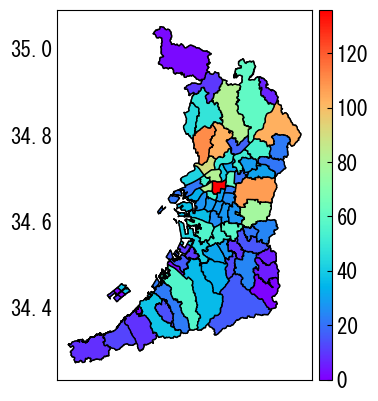

In [75]:
##### PLOT #####

# Make data for colormap
# Create gdf['count'] RealEstate data
arr = []
for i in range(len(gdf)):
    print("gdf['N03_003'][" + str(i) + ']:', gdf['N03_003'][i], ',', "gdf['N03_004'][" + str(i) + ']:', gdf['N03_004'][i])
    
    if gdf['N03_003'].isna()[i] and gdf['N03_004'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True and gdf['N03_004'].isna()["+str(i)+"] == True")
        arr.append(0)
    elif gdf['N03_003'].isna()[i]:
        print("gdf['N03_003'].isna()["+str(i)+"] == True")
        arr.append(df_p.loc[gdf['N03_004'][i]]['No'])
    elif gdf['N03_004'].isna()[i]:
        print("gdf['N03_004'].isna()["+str(i)+"] == True")
    else:
        arr.append(df_p.loc[gdf['N03_003'][i] + gdf['N03_004'][i]]['No'])
# Create a new column
gdf['count'] = arr
# 色を描画
num_color, cmap, norm = colors_scale(gdf['count'])


# # 市町村名をプロット
# # Extract cordinates
# name_df = gdf.groupby(['N03_003', 'N03_004'], dropna=False, as_index=False).mean().loc[:, ['N03_003', 'N03_004', 'x', 'y']]
# name_df.drop(name_df[name_df['N03_004'].isna()].index)  # drop NaN
# # Loop for the length of name_df
# mylist = list(name_df.index)
# for l in mylist:
#     plt.text(name_df['x'][l]-0.01, name_df['y'][l], name_df['N03_004'][l], fontname="MS Gothic", fontsize=15)

# マップをプロット
base = gdf.plot(color=num_color, edgecolor='black')  #ベースをcolor、境界をedgecolorで描画
plt.tick_params(axis='x', labelbottom=False)
plt.tick_params(axis='y', labelbottom=False)

# カラーバーを記載
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig = base.get_figure()
cax = fig.add_axes([base.get_position().x1+0.01, base.get_position().y0, 0.02, base.get_position().height])
cbar = fig.colorbar(sm, cax=cax)
cbar.ax.tick_params()
